In [19]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### NLP: Language Modeling

In this tutorial, we will be building bi-gram language models:
* Bi-gram count based language model
* Bi-gram neural network based language model
* N-gram MLP based lanugae model, insipred by [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)


This tutorial is a summary of my learnings from Andrej Karpathy's [makemore lecture](https://www.youtube.com/watch?v=PaCmpygFfXo) and Chip Huyen's [ML system design](https://huyenchip.com/machine-learning-systems-design/design-a-machine-learning-system.html#design-a-machine-learning-system-dwGQI5R).

Designing a machine learning system is a multi-step iterrative process:
1. Defining the problem
2. Data collection and pre-processing
3. Modelling and Training
4. Evaluation of the model
5. Deployment of the model

Without further ado, let's build our first language model. 

### Bi-gram count based lanugae model

#### 1. Defining the problem
We want to build a machine learning system which can generate new plausible English names for a person. 


#### 2. Data collection
To train a machine learning system we need example dataset. In our case, we will need a dataset of English names.

We will be using the same [names.txt](https://github.com/karpathy/makemore/blob/master/names.txt) used in Andrej Karpathy's makemore lecture series.

Let's explore the dataset.

In [20]:
# read names.txt file
names = None
with open("names.txt",'r') as file:
    names = file.read().splitlines() #splitline will split the text on '\n' character and will return a list of strings

In [21]:
n_names = len(names)
print(f"Total no. of names in the dataset: {n_names}")
print(f"List first few names: {names[:10]}")
lengths = [len(w) for w in names]
print(f"Length of longest word: {max(lengths)} ({names[lengths.index(max(lengths))]}) and shortest word: {min(lengths)} ({names[lengths.index(min(lengths))]})")

Total no. of names in the dataset: 32033
List first few names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Length of longest word: 15 (muhammadibrahim) and shortest word: 2 (an)


Since our goal is to generate new words, we need to tell the model about start and end of a word. To represent the start of a word, \<S> or \<Start> token is used and similarly, to represnt the end of a word \<E> or \<End> token is used. We will be using the same token "**.**" for start and end token.

Create character vocabulary:

In [32]:
# let's create a character vocabulary for names dataset and also add ".", the start token to the vocab
char_vocab = ['.'] + sorted(set("".join(names)))
vocab_size = len(char_vocab)
print(f"{vocab_size=} and characters in vocab: {''.join(char_vocab)}")

# character to index mapping
chartoi = {}
# index to character mapping
itochar = {}
for i, c in enumerate(char_vocab):
    chartoi[c] = i
    itochar[i] = c
print(f"{chartoi=}")
print(f"{itochar=}")

vocab_size=27 and characters in vocab: .abcdefghijklmnopqrstuvwxyz
chartoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itochar={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


Compute all the bi-grams for the names dataset

To compute bi-gram, add "**.**" in the beginning and in the end of each word.

* A bigram is a list of all possible substrings of length 2
* An N-gram is a list of all possible substrings of length N

In [60]:
# bigram:count dictionary of bigrams
bigrams = {}
for i, name in enumerate(names):
    # string to list of characters in the given string
    chars = ['.'] + list(name)+ ['.']
    # sweet way to generate bigrams of a word in python
    for char1, char2 in zip(chars[:-1], chars[1:]):
        bigrams[(char1,char2)] = bigrams.get((char1,char2), 0) + 1
    if i == 0:
        print(f"First word: {name}\n{chars=}\n{bigrams=}")
print(f"Number of bigrams: {len(bigrams)}")

First word: emma
chars=['.', 'e', 'm', 'm', 'a', '.']
bigrams={('.', 'e'): 1, ('e', 'm'): 1, ('m', 'm'): 1, ('m', 'a'): 1, ('a', '.'): 1}
Number of bigrams: 627


If the vocabulary has 27 characters, then the number of possible bigrams is 27*27 = 729

In [61]:
# sort the bigrams wrt count in descending order
bigrams = sorted(bigrams.items(), key=lambda x:x[1],reverse=True)
bigrams

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '.'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('.', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '.'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('.', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('.', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('.', 'l'), 1572),
 (('.', 'c'), 1542),
 (('.', 'e'), 1531),
 (('j', 'a'), 1473),
 (('r', '.'), 1377),
 (('n', 'e'),

What does the bigram count dictionary tell?

(x,y): 9

How many times x followed by y occurred in the dataset

Let's create a count table or matrix for better visualization and understanding of bigram counts
* vertical axis: first character of bigram (total no. of possible characters is vocab_size)
* horizontal axis: second character of bigram (total no. of possible characters is vocab_size)

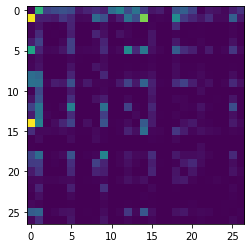

In [62]:
count_table = torch.zeros((vocab_size, vocab_size))

for bigram, count in bigrams:
    ch1, ch2 = bigram
    count_table[chartoi[ch1], chartoi[ch2]] = count
    
plt.imshow(count_table)

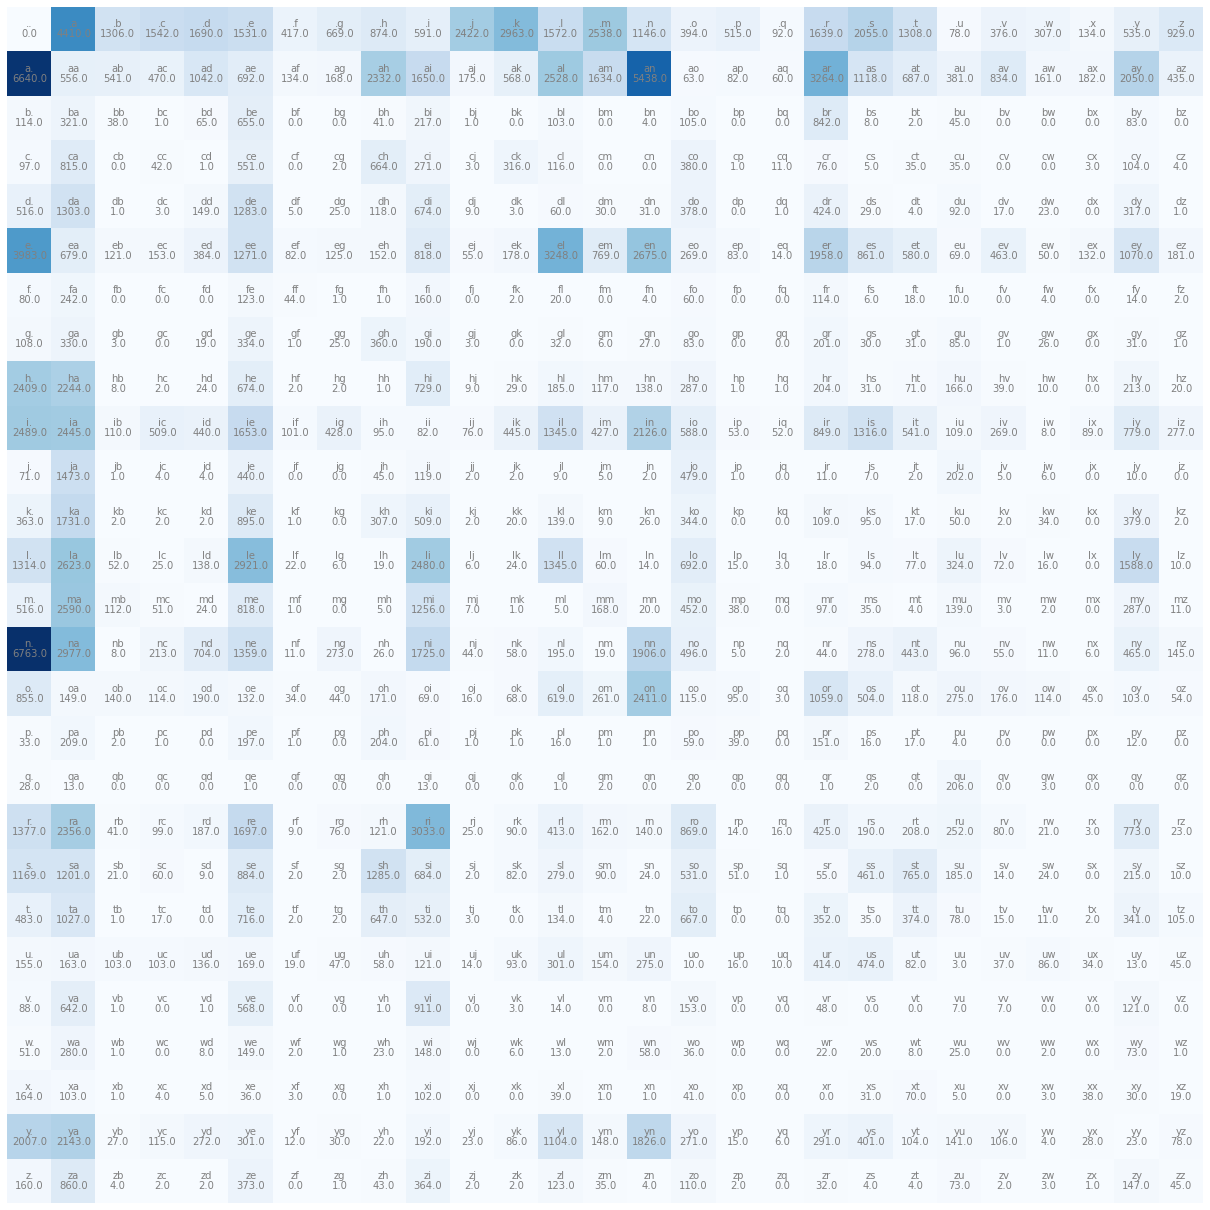

In [68]:
plt.figure(figsize=(22,22))
plt.imshow(count_table, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itochar[i] + itochar[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, count_table[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

#### 4.Modeling

Given current character, predict what would be the next character.

**Baseline:**

A simple baseline model would be: given a character, if all characters have equal probability (1/27=0.037) of occuring as the next character.

**Proposed model**

Learn the probability distribution over all the characters (entire vocabulary) given a character. There are two ways to use this probability distribution to predict the next character given a character:
* Predict the character with maximum probablity, but this would generate only one word for a fixed starting character.
* Sampling from the probability distribution will solve the above problem; now, for a fixed starting character, we can generate many different words because every time, a different sample will be generated from the distribution (with replacement).

We can use the count_table to get these probabilities.